In [102]:
import os
import json
from langchain.schema import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_ollama import ChatOllama
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langgraph.graph import END
from langgraph.graph import StateGraph
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict
from dotenv import load_dotenv
load_dotenv()

tavily_api_key = os.getenv("TAVILY_API_KEY")


In [103]:
web_search_tools = TavilySearchResults(k=3)
local_llm = 'llama3.2:3b'
llm = ChatOllama(model=local_llm)
llm_json = ChatOllama(model=local_llm, format='json', temperature=0)

In [98]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist] 

In [99]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
docs_split = text_splitter.split_documents(docs_list)

vectorstore = FAISS.from_documents(
    docs_split, embedding=OllamaEmbeddings(model="nomic-embed-text")
)
retriever = vectorstore.as_retriever(k=3)

In [100]:
print(retriever.invoke("agent memory"))

[Document(id='5507858f-398c-45b2-a4a4-9440d62f3089', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [104]:

router_instructions = """
You are an expert at routing a user question to a vector store or web search.
The vectorstore Contains documents related to agents, prompt engineering and adversarial attacks.
Use the vector store for questions on these topics. For all else, and especially for current events, use web search.
Return a json with single key, 'datasource' that is 'websearch' or 'vectorstore', depending on the question.
"""

question = [HumanMessage(content="What are the types of agent memory?")]
test_vector_store = llm_json.invoke(
    [SystemMessage(content=router_instructions)] + question
)
json.loads(test_vector_store.content)  

{'datasource': 'vectorstore'}

In [15]:
doc_grader_instructions = """
You are a grader assessing relevance af a retrieved document to a user question.
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
"""

doc_grade_prompt = """
Here is the retrieved document: \n\n {document}
Here is the user question: \n\n{question}
This carefully and objectively assess whether the document contains at least some information that is relevant to the question.
Return json with single key, binary_score that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant or not.
"""

question = "what is chain of thought prompting?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grade_prompt_formatted = doc_grade_prompt.format(
    document=doc_txt, question=question
)
result = llm_json.invoke(
    [
        SystemMessage(content=doc_grader_instructions)
    ]
    + 
    [
        HumanMessage(content=doc_grade_prompt_formatted)
    ]
)
print(json.loads(result.content))

{'binary_score': 'yes'}


In [16]:
print(doc_txt)

References#
[1] Zhao et al. “Calibrate Before Use: Improving Few-shot Performance of Language Models.” ICML 2021
[2] Liu et al. “What Makes Good In-Context Examples for GPT-3?” arXiv preprint arXiv:2101.06804 (2021).
[3] Lu et al. “Fantastically Ordered Prompts and Where to Find Them: Overcoming Few-Shot Prompt Order Sensitivity.” ACL 2022
[4] Ye et al. “In-Context Instruction Learning.” arXiv preprint arXiv:2302.14691 (2023).
[5] Su et al. “Selective annotation makes language models better few-shot learners.” arXiv preprint arXiv:2209.01975 (2022).
[6] Rubin et al. “Learning to retrieve prompts for in-context learning.” NAACL-HLT 2022
[7] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022
[8] Wang et al. “Self-Consistency Improves Chain of Thought Reasoning in Language Models.” ICLR 2023.
[9] Diao et al. “Active Prompting with Chain-of-Thought for Large Language Models.” arXiv preprint arXiv:2302.12246 (2023).
[10] Zelikman et al. “STaR: B

In [17]:
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Use three sentences maximum and keep the answer concise.

Answer:"""

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

This text appears to be a comprehensive overview of various techniques used in Large Language Models (LLMs) to enhance their performance on complex tasks. The techniques discussed can be broadly categorized into the following areas:

1. **Planning**: Techniques that enable LLMs to break down large tasks into smaller, manageable subgoals and plan ahead.
2. **Memory**: Techniques that allow LLMs to retain and recall information over extended periods, often by leveraging external vector stores and fast retrieval.
3. **Tool use**: Techniques that enable LLMs to access external APIs for extra information that is missing from the model weights.

Some specific techniques discussed in the text include:

1. **Chain of Thought (CoT)**: A prompting technique that instructs the model to "think step by step" to decompose hard tasks into smaller and simpler steps.
2. **Tree of Thoughts**: An extension of CoT that explores multiple reasoning possibilities at each step, creating a tree structure.
3. *

In [ ]:
print(web_search_tools.invoke("LLM agents"))

[{'url': 'http://rdi.berkeley.edu/llm-agents/f24', 'content': 'In this course, we will first discuss fundamental concepts that are essential for LLM agents, including the foundation of LLMs, essential LLM abilities required for task automation, as well as infrastructures for agent development. All enrolled students are expected to participate in lectures in person and complete weekly reading summaries related to the course content. Students enrolling in one unit are expected to submit an article that summarizes one of the lectures. Students enrolling in more than one unit are expected to submit a lab assignment and a project instead of the article.'}, {'url': 'https://developer.nvidia.com/blog/introduction-to-llm-agents', 'content': 'Demystifying Retrieval-Augmented Generation Pipelines\nBuild Enterprise Retrieval-Augmented Generation Apps with NVIDIA Retrieval QA Embedding Model\nTraining a Text2Sparql Model with MK-SQuIT and NeMo\nRelated posts\nDevelop Custom Enterprise Generative A

In [ ]:
hallucination_grader_instructions = """

You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt, generation=generation.content
)
result = llm_json.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': "The STUDENT ANSWER provides a comprehensive overview of various techniques used in Large Language Models (LLMs) to enhance their performance on complex tasks, which is grounded in the facts presented in the text. The answer accurately categorizes the discussed techniques into planning, memory, and tool use, and provides specific examples of each technique, including Chain of Thought (CoT), Tree of Thoughts, task decomposition, self-reflection, and ReAct. The answer also highlights the importance of providing complex prompts with demonstrations of higher reasoning complexity to achieve better performance, which is consistent with the text. Therefore, the binary score is 'yes', indicating that the STUDENT ANSWER is grounded in the facts."}

In [23]:
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

question = "What are the vision models released today as part of Llama 3.2?"
answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct, which are available on Azure AI Model Catalog via managed compute. These models are part of Meta's first foray into multimodal AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the older text-only Llama 3.1 models."

answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question, generation=answer
)
result = llm_json.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)
print(json.loads(result.content))

{'binary_score': 'yes', 'explanation': "The student's answer helps to answer the question by providing specific details about the vision models released as part of Llama 3.2, including their names and availability on Azure AI Model Catalog. The answer also provides context about the models' capabilities and how they compare to other multimodal AI models. While the answer contains some extraneous information (e.g., the comparison to Claude 3 Haiku and GPT-4o mini), it still meets all of the criteria for answering the question, which is to identify the vision models released as part of Llama 3.2."}


In [75]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    question: str
    generation: str   
    web_search: str
    answers: int
    max_retries: int
    loop_step: int
    documents: List[str] 

In [76]:
def retrieve(state: GraphState):  
    """
    Retrieve documents from vectorstore
    """
    print("---RETRIEVE---")
    question = state["question"]

    documents = retriever.invoke(question)
    return {"documents": documents}

In [77]:
def generate(state: GraphState):   
    """
    Generate answer using RAG
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    docs_txt = format_docs(documents)   
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation_content = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

    return {"generation": generation_content, "loop_step": loop_step + 1}

In [78]:
def grade_documents(state: GraphState):
    print("---CHECK DOCUMENT RELEVANCE---")
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grade_prompt_formatted = doc_grade_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grade_prompt_formatted)])
        try:  
            grade = json.loads(result.content)['binary_score']
        except json.JSONDecodeError as e:
            print(f"JSON Decode Error: {e}")
            print(f"Problematic Output: {result.content}")  
            grade = "no"  

        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}


In [79]:
def web_search(state: GraphState):
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    docs = web_search_tools.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_result_doc = Document(page_content=web_results, metadata={"source": "web_search"})  # Add metadata
    documents.append(web_result_doc)  
    return {"documents": documents}

In [80]:
def route_question(state: GraphState):
    """
    Route question to web search or RAG.
    """
    print("---ROUTER---")
    question = state["question"]
    router_question = llm_json.invoke(
        [SystemMessage(content=router_instructions)] + [HumanMessage(content=question)]
    )
    source = json.loads(router_question.content)['datasource']
    
    if source == "websearch":
        print("---ROUTER: WEB SEARCH---")
        return "websearch"
    
    elif source == "vectorstore":
        print("---ROUTER: VECTOR STORE---")
        return "vectorstore"
    

In [82]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else: 
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)   

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content
    )
    result = llm_json.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")
    
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation   
        )

        result = llm_json.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

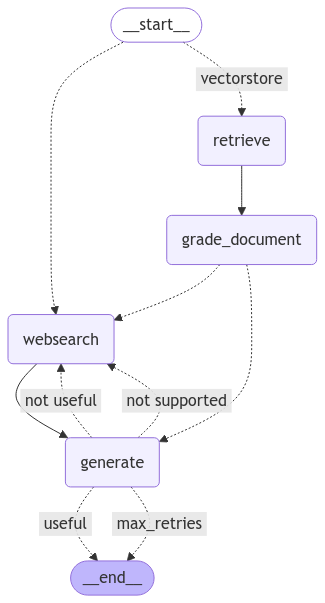

In [83]:
workflow = StateGraph(GraphState)

workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_document", grade_documents)
workflow.add_node("generate", generate)

workflow.set_conditional_entry_point(
    route_question, 
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_document")
workflow.add_conditional_edges(
    "grade_document",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "not useful": "websearch",
        "not supported": "websearch",
        "max_retries": END,
    },
)

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
inputs = {"question": "What are the types of agent memory?", "max_retries": 3}
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTER---
---ROUTER: VECTOR STORE---
{'question': 'What are the types of agent memory?', 'max_retries': 3}
---RETRIEVE---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'documents': [Document(id='6b94a28e-48dc-4e43-b08e-82f9f387d651', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable s